# Compute a "Global Bouguer" using SH models and SHTOOLS

This notebook aims at computing a *topography-reduced gravity disturbance* (or *complete Bouguer disturbance*, or *NETC disturbance*) starting from the spherical harmonics coefficients of a global gravity field model and a synthetic model of the effect of topography, ice, and water. It relies on [SHTOOLS](https://shtools.oca.eu/shtools/public/) (Wieczorek and Meschede, 2018, [doi:10.1029/2018GC007529](https://doi.org/10.1029/2018GC007529)), using _pyshtools_ functions and classes.

In its first incarnation, this was set up to try SHTOOLS out of curiosity and, after a bit of trial and error, to successfully compute a consistent Bouguer disturbance, which *should* be a trivial task.
This means obtaining the following, as in Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26):

$\delta g_{tr} (h, \lambda, \phi) = \left | \nabla \left[ W (h, \lambda, \phi) - V_t (h, \lambda, \phi) \right ] \right | - \left | \nabla U (h, \phi) \right |$

where the order of differences and norms is, unsurprisingly, of utmost importance.

This notebook was set up with the following gravity models, downloaded in the gfc format from [ICGEM](http://icgem.gfz-potsdam.de/home):

* Input global gravity model: **XGM2019e**, Zingerle, P., Pail, R., Gruber, T., Oikonomidou, X. (2019): The experimental gravity field model XGM2019e. *GFZ Data Services*. [doi:10.5880/ICGEM.2019.007](http://doi.org/10.5880/ICGEM.2019.007).

* Topographic effect model: **dV_ELL_Earth2014**, Rexer, M., Hirt, C., Claessens, S., Tenzer, R. (2016): Layer-based modelling of the Earth's gravitational potential up to 10km-scale in spherical harmonics in spherical and ellipsoidal approximation. *Surveys in Geophysics*. [doi:10.1007/s10712-016-9382-2](https://doi.org/10.1007/s10712-016-9382-2).

When run in Binder, these two models are downloaded and unzipped after the container is built, using the [`binder/PostBuild`](./binder/PostBuild) script.
If run locally, `binder/PostBuild` must be executed beforehand.
In alternative, download two models of choice and edit the calls to read_icgem_gfc accordingly (or use any other appropriate loading method).

The code below should work with any other combination of models with a maximum SH degree equal or greater than the maximum SH degree of the required grid. Otherwise, zero-padding the missing high degrees is needed.
Note that the topographic effect model does not include the normal potential.

#### ⚠️ Disclaimer

Keep in mind that this example deals with computing a *topography-reduced gravity disturbance*, as described in Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26), using SHTOOLS and gfc files downloaded from ICGEM.
Its aim is keeping formal consistency in the computation - a trivial task, albeit prone to errors.
Apart from this, for this purposes, any other issue was deemed of secondary importance (to a reasonable extent). Thus I must warn against using the 'Bouguer disturbance' here obtained in any application.

Double check everything, first: both for formal correctness and for consistency between code and theory.
Any feedback is welcome!


In [1]:
%matplotlib inline
import numpy as np
import pyshtools
import cartopy.crs as ccrs

# set figure style (pyshtool defaults, set dpi)
pyshtools.utils.figstyle(screen_dpi=160)

## Read the input models (gfc files)

Variable naming convention

- `GGM` global gravity model
- `GTM` global topographic effect model
- `Tbg` disturbing potential corrected for the topographic masses.


In [2]:
GGM_filename = 'XGM2019e_2159.gfc'
GTM_filename = 'dV_ELL_Earth2014.gfc'

In [3]:
%%time
GGM_cilm, GGM_gm, GGM_r0 = \
    pyshtools.shio.read_icgem_gfc(GGM_filename)

CPU times: user 8.87 s, sys: 389 ms, total: 9.26 s
Wall time: 9.24 s


In [4]:
%%time
GTM_cilm, GTM_gm, GTM_r0 = \
    pyshtools.shio.read_icgem_gfc(GTM_filename)

CPU times: user 8.73 s, sys: 358 ms, total: 9.09 s
Wall time: 9.08 s


From $C_{l,m}$ arrays to the `pyshtools.SHGravCoeffs` class, using the `from_array` constructor method.

Note that we are providing the angular velocity of rotation ($\omega$) for the GGM only - it is set to zero for the terrain effect model. Failure to do so results in the centrifugal potential (absent from the TC model) being incorrectly removed.

In [5]:
GGM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GGM_cilm, GGM_gm, GGM_r0,
    omega=pyshtools.constants.Earth.wgs84.omega.value)

GTM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GTM_cilm, GTM_gm, GTM_r0,
    omega=0)

If the maximum degrees ($l_{max}$) of the SH expansions are not equal, zero-pad up to the same $l_{max}$.

In [6]:
lmax_max = max(GGM_coeffs.lmax, GTM_coeffs.lmax)

if GGM_coeffs.lmax < lmax_max:
    GGM_coeffs.pad(lmax=lmax_max, copy=False)
if GTM_coeffs.lmax < lmax_max:
    GTM_coeffs.pad(lmax=lmax_max, copy=False)

The GGM and the topography effect model may not share the same reference ($GM$ and $r_0$).

In [7]:
print(' *** Gravity model properties *** ')
GGM_coeffs.info()
print('\n *** Terrain effect model properties ***')
GTM_coeffs.info()

 *** Gravity model properties *** 
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 2190
GM (m3 / s2) = 398600441500000.0
r0 (m) = 6378136.3
Omega (rad / s) = 7.292115e-05
error_kind = None
header = None
header2 = None
name = None
epoch = None

 *** Terrain effect model properties ***
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 2190
GM (m3 / s2) = 398600500000000.0
r0 (m) = 6378137.0
Omega (rad / s) = 0
error_kind = None
header = None
header2 = None
name = None
epoch = None


We re-reference both to the same reference, using $GM$ from the gravity model (`GGM_gm`) and a new reference radius $r_0$ equal to the largest between the two reference radii (to avoid performing any downward continuation).

The upward continuation to this new value assumes this radius lies outside any masses (documentation: see [1](https://shtools.oca.eu/shtools/public/python-shgravcoeffs.html), [2](https://github.com/SHTOOLS/SHTOOLS/blob/6fdd2f420ceb61b5fe482793db1f6762f1d88ddb/pyshtools/shclasses/shgravcoeffs.py))

Changing $GM$ implies re-scaling coefficients proportionally to the ratio to the new $GM$.

Changing $r_0$ follows this degree-wise rescaling of all coefficients (original $r_{0,1}$ to new $r_{0,2}$) by this factor:

$\displaystyle \left( \frac{r_{0,1}}{r_{0,2}} \right)^l$

In [8]:
r0_max = max(GGM_coeffs.r0, GTM_coeffs.r0)

GGM_coeffs = GGM_coeffs.change_ref(gm=GGM_gm, r0=r0_max)
GTM_coeffs = GTM_coeffs.change_ref(gm=GGM_gm, r0=r0_max)

## Apply the terrain correction

Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26) described above is implemented by:
1. computing the difference between the gravity model and the terrain gravity effect model, in terms of their SH coefficients (both are in the same form: unitless, same normalization, same reference radius)
2. synthesising (`expand()` method) the terrain-corrected field to gravity grids (an istance of the `pyshtools.SHGravGrid` class), computed at the surface of a provided ellipsoid. The $\omega$ value stored in the `GGM_coeffs` is used to remove the normal gravity to the terrain-corrected field.
3. we obtain the no-topography gravity disturbance in the `SHGrid` instance in `Tbg_grid.total`

This amounts to:

- unitless SH coefficients of the no-topography gravity field, normal potential included:

$\overline{C_{l,m}^{W_{NT}}} = \overline{C_{l,m}^{W}} - \overline{C_{l,m}^{V_T}}$

where $\overline{C_{l,m}^{W}}$ are the unitless SH coefficients of the gravity field, and $\overline{C_{l,m}^{V_T}}$ the unitless SH coefficients.

All coefficients are $4 \pi$ _fully normalized spherical harmonic coefficients_, representing the field at the same reference radius $r_0$.

- gravity disturbance grid

$\delta g_{tr} (r, \theta, \lambda) = \left[ \displaystyle \frac{GM}{r^2} \sum_{l=0}^{l_{max}} \left( \frac{R}{r} \right)^l (l-1) \sum_{m=0}^l \overline{C_{l,m}^{W_{NT}}} \, \overline{Y_{l,m}} (\lambda, \phi) \right] - \left | \nabla U (h, \phi) \right |$

Where $\overline{Y_{l,m}}$ are the $4 \pi$ _fully normalized spherical harmonics_ in this notation:

$\overline{Y_{l,m}}(\theta, \lambda) = \overline{P_{l,|m|}}(\cos{\theta}) Q_m (\lambda)$

With $\overline{P_{l,|m|}}(\cos{\theta})$ $4 \pi$ _fully normalized associated Legendre function_ of degree $l$ and order $m$, and:

$Q_m (\lambda) =
\begin{cases}
    \cos{(m \lambda)},& m \ge 0\\
    \sin{(|m| \lambda)},& m < 0
\end{cases}$

Note that this approach employs the Somigliana equation to compute $\left | \nabla U (h, \phi) \right |$.
An alternative method, computing the coefficient of the disturbing potential, is provided in [GrafLab](https://www.svf.stuba.sk/en/departments/department-of-theoretical-geodesy/science-and-research/downloads.html?page_id=4996) ([Bucha and Janák, 2013](http://dx.doi.org/10.1016/j.cageo.2013.03.012)).

In [9]:
Tbg_coeffs = GGM_coeffs - GTM_coeffs

The grid synthesis up to degree $l_{max}$ takes a while (around 2.5 minutes, on a single core of a VM in a local cluster node. Time on binder or on your local machine may vary).

To speed thing up, we may truncate to a lower maximum degree. However, the Authors of Earth2014 warn against this, in the header of `dV_ELL_Earth2014.gfc`. The model:

> "always should be evaluated to its maximum degree ($N_{max}=2190$), since the last 30 coefficients account for the ellipsoidal shape of Earth. Neglecting this "tail" of coefficients or truncating the model at lower degrees during SHS will result in severe error patterns, especially at high latitudes."

See also: Rexer, M., Hirt, C., Claessens, S., Tenzer, R. (2016) "Layer-based modelling of the Earth's gravitational potential up to 10km-scale in spherical harmonics in spherical and ellipsoidal approximation", *Surveys in Geophysics*, [doi:10.1007/s10712-016-9382-2](https://doi.org/10.1007/s10712-016-9382-2).


In [10]:
%%time
Tbg_grid = Tbg_coeffs.expand(
    normal_gravity=True,
    a=r0_max, f=pyshtools.constants.Earth.wgs84.f.value)

CPU times: user 2min 30s, sys: 863 ms, total: 2min 31s
Wall time: 2min 31s


In [11]:
Tbg_grid.info()

grid = DH
nlat = 4383
nlon = 8765
n = 4382
sampling = 2
extend = True
lmax = 2190
lmax_calc = 2190
gm (m3 / s2) = 3.986004e+14
a (m)= 6.378137e+06
f = 3.352811e-03
omega (rad / s) = 7.292115e-05
normal gravity is removed = True
units (gravity) = 'm/s2'
units (potential) = 'm2/s2'
epoch = None


## Maps

Set the projection:

In [12]:
projection = ccrs.Robinson()

Maps of the three vector components of gravity ($g_r$, positive upwards; $g_\theta$; $g_\phi$) and of the gravity disturbance ($\delta g$, positive downwards).

All are reduced for the topography effect.

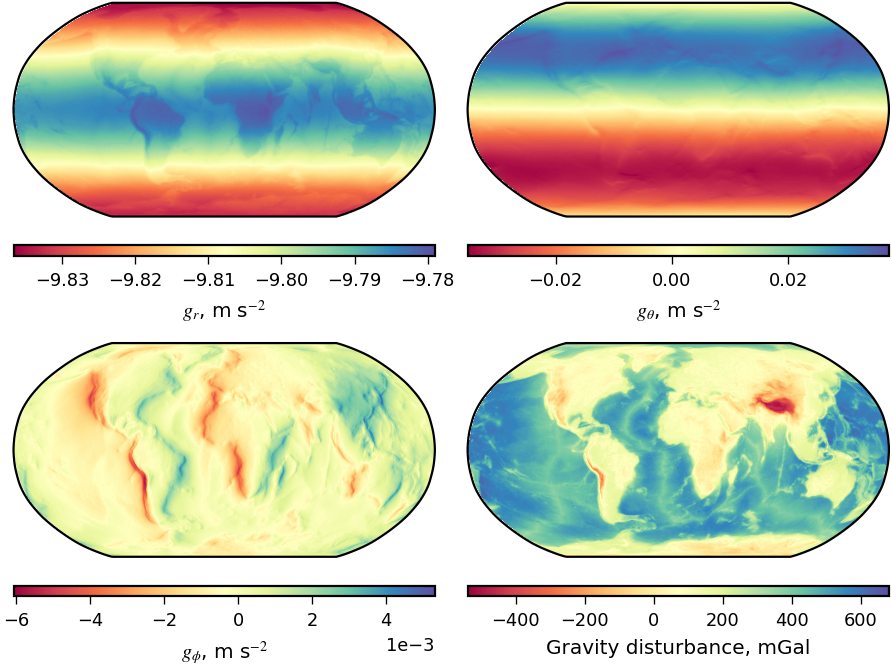

In [13]:
_ = Tbg_grid.plot(show=False,
                  cmap='Spectral',
                  projection=projection)

Map of the gravity disturbance alone. The colormap is clipped to two quantiles, to keep extreme values out (in favour of contrast).

(a rigorous quantile computation of a regular lon-by-lat grid should be area weighted, using the cosine of latitude)

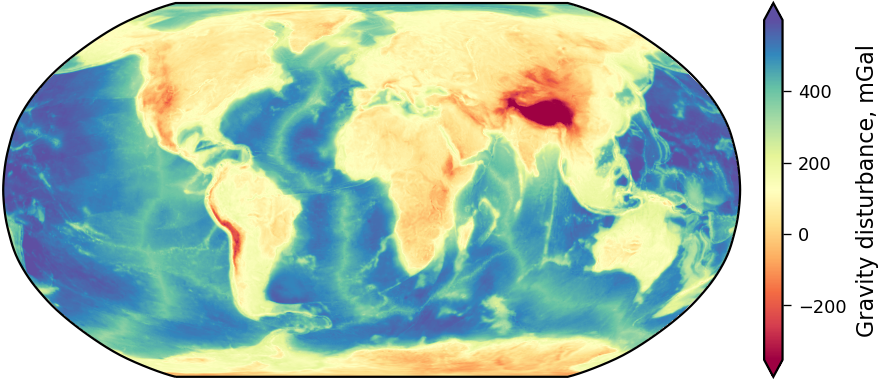

In [14]:
_ = Tbg_grid.plot_total(show=False,
                        cmap='Spectral',
                        projection=projection,
                        cmap_limits=[  # data in property is in m/s^2, convert
                            np.quantile(Tbg_grid.total.data * 1e5, 0.003),
                            np.quantile(Tbg_grid.total.data * 1e5, 0.997)
                        ], cb_triangles="both",)

## Save to file, for further use

Export to a NetCDF file, which is also suitable for import in [GMT](https://www.generic-mapping-tools.org/).

In [15]:
Tbg_grid.total.to_netcdf(filename="XGM2019e_E2014_BG.nc", units="m/s2", dtype="f")